<h3> 🌌 Dataset Description</h3>

<p>You will have access to a training set and a test set. The training set contains the position and velocity measurements of the three bodies for different time steps. You sholid use this data to train your model and learn to propagate the trajectories of the objects. The test set contains an initial position and several time steps. Using your trained model, you sholid predict the positions of the three objects starting from the initial position. Additionally, you have access to a sample submission. This is an example of what your submission files sholid look like so that the system can accept them welwelelelelee.</p>

<h5>📁 Files</h5>
<ul>
  <li><code>X_train.csv</code> — training set (1,285,000 rows, 14 cols; 5000 trajectories × 257 timesteps)</li>
  <li><code>X_test.csv</code> — test set (1,041,621 rows, 8 cols; 4053 trajectories × 257 timesteps)</li>
  <li><code>sample_submission.csv</code> — example in the correct format (random predictions)</li>
</ul>

<h4>X_train Columns</h4>
<ul>
  <li><code>Id</code> — row index (use <code>traj_id = Id // 257</code>)</li>
  <li><code>t</code> — timestep</li>
  <li><code>x_1, y_1, v_x_1, v_y_1</code> — position/velocity of object 1</li>
  <li><code>x_2, y_2, v_x_2, v_y_2</code> — position/velocity of object 2</li>
  <li><code>x_3, y_3, v_x_3, v_y_3</code> — position/velocity of object 3</li>
</ul>

<h4>X_test Columns</h4>
<ul>
  <li><code>Id</code> — row id (257 rows per trajectory)</li>
  <li><code>t</code> — timestep</li>
  <li><code>x0_1, y0_1</code> — object 1 initial position (t=0)</li>
  <li><code>x0_2, y0_2</code> — object 2 initial position (t=0)</li>
  <li><code>x0_3, y0_3</code> — object 3 initial position (t=0)</li>
</ul>

<p><b>Note:</b> After a collision, remaining rows in that trajectory are zero-padded (features become zero; <code>t</code> may be 0). Exclude these rows when training/validating.</p>



<h3>📚 Imports</h3>

In [1]:
import matplotlib.pyplot as plt                        # Library for plotting graphs and visualizations
import numpy as np                                     # Library for numerical computing (arrays, math functions)
import pandas as pd                                    # Library for handling datasets (tables, CSVs, DataFrames)
from sklearn.metrics import mean_squared_error , root_mean_squared_error  # Function to evaluate model performance using MSE
from sklearn.model_selection import train_test_split   # Utility to split dataset into training and testing sets
from sklearn.preprocessing import StandardScaler       # Tool to normalize/standardize features
from sklearn.preprocessing import PolynomialFeatures   # Generates polynomial features for non-linear regression
from sklearn.pipeline import make_pipeline             # Builds pipelines that chain preprocessing + model steps
from sklearn.linear_model import LinearRegression      # Ordinary least squares linear regression model
from sklearn.linear_model import Ridge, RidgeCV        # Ridge regression (L2 regularization) and Ridge with cross-validation
from sklearn.compose import ColumnTransformer          # Apply transformations to specific columns of the dataset
from sklearn.preprocessing import FunctionTransformer  # Apply custom functions to transform data
import time                                            # Python built-in library to measure execution time
import seaborn as sns                                  #Statistical data visualization                           


<h3>📂 Load Data</h3>

In [2]:
data = pd.read_csv("~/Downloads/X_train.csv")
test = pd.read_csv("~/Downloads/X_test.csv")


In [4]:
data.head()  # Display the first few rows of the dataset to understand its structure

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
0,0.000000,1.000000,0.000000,0.000000,0.000000,-0.266467,0.859196,0.000000,0.000000,-0.733533,-0.859196,0.000000,0.000000,0
1,0.039062,0.999548,0.000092,-0.023159,0.004731,-0.266261,0.858781,0.010574,-0.021257,-0.733287,-0.858874,0.012584,0.016526,1
2,0.078125,0.998190,0.000370,-0.046362,0.009474,-0.265641,0.857535,0.021172,-0.042552,-0.732549,-0.857905,0.025189,0.033078,2
3,0.117188,0.995925,0.000833,-0.069654,0.014239,-0.264606,0.855456,0.031817,-0.063924,-0.731318,-0.856289,0.037837,0.049685,3
4,0.156250,0.992747,0.001483,-0.093080,0.019040,-0.263154,0.852540,0.042533,-0.085412,-0.729592,-0.854022,0.050548,0.066372,4


In [5]:
data.columns  # List all column names to identify features and target variable

Index(['t', 'x_1', 'y_1', 'v_x_1', 'v_y_1', 'x_2', 'y_2', 'v_x_2', 'v_y_2',
       'x_3', 'y_3', 'v_x_3', 'v_y_3', 'Id'],
      dtype='object')

In [21]:
idx = np.hstack((0,data[data.t==10].index.values +1))  # Indices where each trajectory starts (t=0)
idx.shape, data.t.min(), data.t.max()  # Check number of trajectories and time range

((4054,), 0.0, 10.0)

760


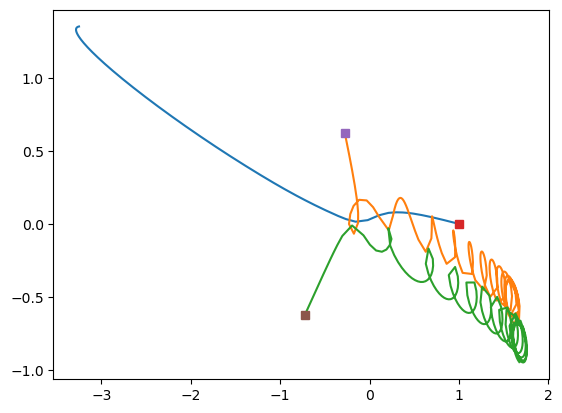

In [22]:
k = np.random.randint(idx.shape[0])  # Pick a random trajectory index
print(k)
plitdx = range(idx[k],257+idx[k])  # Get the row indices for that trajectory
pltsquare = idx[k]   # Determine the subplot position based on trajectory index
plt.plot(data.x_1[plitdx],data.y_1[plitdx])  # Plot the trajectory of object 1
plt.plot(data.x_2[plitdx],data.y_2[plitdx])  # Plot the trajectory of object 2
plt.plot(data.x_3[plitdx],data.y_3[plitdx])  # Plot the trajectory of object 3

plt.plot(data.x_1[pltsquare],data.y_1[pltsquare],'s')  # Mark the starting point of object 1
plt.plot(data.x_2[pltsquare],data.y_2[pltsquare],'s')  # Mark the starting point of object 2
plt.plot(data.x_3[pltsquare],data.y_3[pltsquare],'s')  # Mark the starting point of object 3

<h2>📝 Task 1 - Setting the Baseline</h2>
<h3>Task 1.1 - Data Preparation and Validation Pipeline</h3>

<h3>🧩 Preprocessing (trajectory id, padding, initial conditions)(Reusable)</h3>

In [3]:
#Creates a unique identifier for each trajectory
#Essential to group lines by trajectory (to exclude collisions and make correct division)
def add_traj_id(df, steps_per_traj= 257):
    df = df.copy() # Avoid modifying the original DataFrame
    df["traj_id"] = df.index// steps_per_traj #Each trajectory has 257 steps, e.g index 0-256 -> traj_id 0, index 257-514 -> traj_id 1, etc.
    return df

#Identifies all the lines that have a colision with True
#Essential for filtering colisions and the trajectories with colisions 
def mark_padding(df):
    df= df.copy()
    feat_cols = [
        'x_1','y_1','v_x_1','v_y_1',
        'x_2','y_2','v_x_2','v_y_2',
        'x_3','y_3','v_x_3','v_y_3'
    ]
    df["is_padding"] = (df[feat_cols].sum(axis=1) == 0) #If all feature columns are zero, mark as padding
    return df

#Identifies the initial position of each trajectorie and puts with x0_* and y0_*
#Essential to use the starting positions as static features.
def add_initial_positions(df):
    df = df.copy()
    first = df.loc[df.groupby("traj_id")["t"].idxmin(), # Get the first row (t=0) for each trajectory
        ["traj_id","x_1","y_1","x_2","y_2","x_3","y_3"]].rename(columns={
        "x_1":"x0_1","y_1":"y0_1",
        "x_2":"x0_2","y_2":"y0_2",
        "x_3":"x0_3","y_3":"y0_3"
    })
    #Get the positions x,y for t=0 and rename the columns to x0_*, y0_* for each object
    df = df.merge(first, on="traj_id", how="left")
    return df 

#Pipeline
#Essential to make the model fully reusable
def preprocess_train(df, steps_per_traj=257):
    df=add_traj_id(df, steps_per_traj=steps_per_traj)
    df=mark_padding(df)
    df=add_initial_positions(df)
    return df #Final dataset with traj_id, is_padding, x0_*, y0_*, x_*, y_*, v_x_*, v_y_*

<h3>Exploration + grafic Functions (insightful)</h3>

In [4]:
#Dataset visualization
#Important for exploring and documenting the database
def dataset_overview(df):
    n_rows, n_cols = df.shape # Get number of rows and columns
    n_traj = df["traj_id"].nunique() # Count unique trajectories
    steps_per_traj = df.groupby("traj_id")["t"].size() # Steps per trajectory
    padding_pct = 100 * df["is_padding"].mean()  # Percentage of padding rows

    info = pd.DataFrame({
        "Metric": [
            "Rows", 
            "Cols",
            "Number of trajectories with paddings",
            "Steps per trajectory (min)",
            "Steps per trajectory (max)",
            "Steps per trajectory (mean)",
            "% Padding rows",
            "Range of time [min,max]"
        ],
        "value": [
            n_rows, n_cols,
            n_traj,
            steps_per_traj.min(),
            steps_per_traj.max(),
            f"{steps_per_traj.mean():.2f}",
            f"{padding_pct:.2f}%",
            f"[{df['t'].min()}, {df['t'].max()}]"
        ]
    })
    return info

#Finds the trajectories that were classified has True in padding
#Important for insight into dynamics and collisions
def find_collision_traj(df):
    has_pad = df.groupby("traj_id")["is_padding"].any() # Check which trajectories have any padding
    cand = has_pad[has_pad].index # Get the ID of those with padding
    return int(np.random.choice(cand)) if len(cand) > 0 else None # Return a random ID with padding 

#Histogram of non_paddings trajectories 
def plot_hist_nonpadding_lengths(df):
    g = df.groupby("traj_id") # Group by trajectory ID
    lengths = (g["is_padding"].apply(lambda s: (~s).sum())).values #Counts non-padding (True) rows per trajectory
    plt.figure(figsize=(6,4))
    plt.hist(lengths, bins=30)
    plt.xlabel("Non-padding length per trajectory")
    plt.ylabel("Count")
    plt.title("Distribution of non-padding trajectories")
    plt.show()
 
#Plots a random trajectory
def plot_one_trajectory(df, traj_id=None, title_prefix="Trajectory"):
    if traj_id is None:
        traj_id = np.random.choice(df["traj_id"].unique())

    d = df.loc[df["traj_id"] == traj_id].sort_values("t") #Filter the datatset to only contain the lines of the selected trajectory
    plt.figure(figsize=(6,6))
    #Plot the trajectory of objects
    plt.plot(d["x_1"], d["y_1"], label="obj 1") 
    plt.plot(d["x_2"], d["y_2"], label="obj 2")
    plt.plot(d["x_3"], d["y_3"], label="obj 3")
    #Initial positions
    plt.plot(d["x_1"].iloc[0], d["y_1"].iloc[0], 's') 
    plt.plot(d["x_2"].iloc[0], d["y_2"].iloc[0], 's')
    plt.plot(d["x_3"].iloc[0], d["y_3"].iloc[0], 's')
    plt.axis('equal')
    plt.legend()
    plt.title(f"{title_prefix} {traj_id}")
    plt.show()

#Histogram of timestep t
def plot_t_hist(df):
    plt.figure(figsize=(6,4))
    plt.hist(df["t"], bins=50)
    plt.xlabel("t")
    plt.ylabel("Count")
    plt.title("Histogram of timestep t")
    plt.show()


<h3>Exploration + Preparation Execution ( with print for slides)</h3>

,Metric,value
0,Rows,1285000
1,Cols,22
2,Number of trajectories with paddings,5000
3,Steps per trajectory (min),257
4,Steps per trajectory (max),257
5,Steps per trajectory (mean),257.00
6,% Padding rows,15.32%
7,"Range of time [min,max]","[0.0, 10.0]"


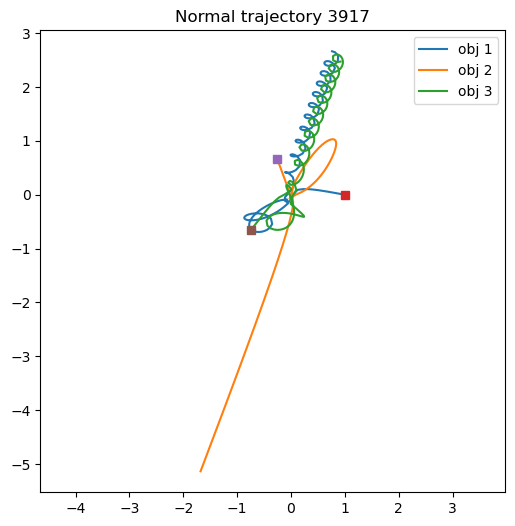

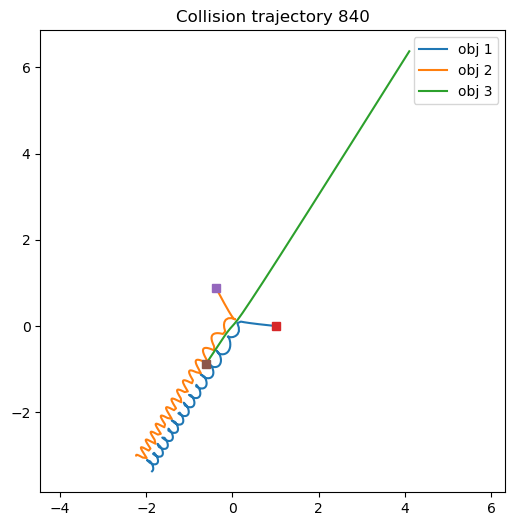

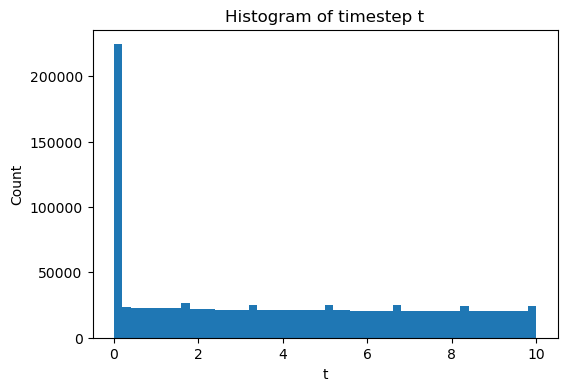

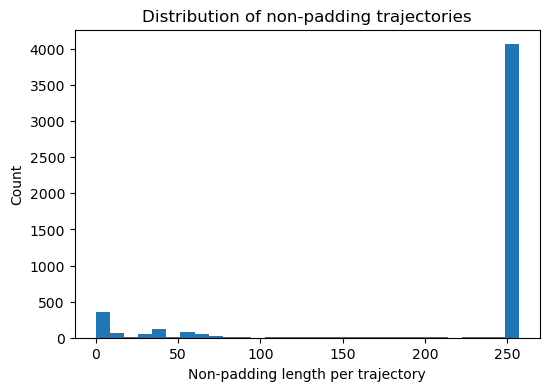

In [6]:
#Show the results
train = preprocess_train(data, steps_per_traj=257)
overview = dataset_overview(train)
display(overview)
plot_one_trajectory(train, traj_id=None, title_prefix="Normal trajectory")
col_traj = find_collision_traj(train)
if col_traj is not None:
    plot_one_trajectory(train, traj_id=col_traj, title_prefix="Collision trajectory")
else:
    print("No collision trajectories found (no padding).")

plot_t_hist(train)
plot_hist_nonpadding_lengths(train)


<h3>✂️ Custom Split by Trajectory</h3>

In [9]:
####Splitting the data

#Definition of features and targets
FEATURES = ["t","x0_1","y0_1","x0_2","y0_2","x0_3","y0_3"]
TARGETS  = ["x_1","y_1","x_2","y_2","x_3","y_3"]

#Defining split function in 70% train, 15% test and 15%validation
def make_train_val_test_split(
    dataset: pd.DataFrame,
    features: list = FEATURES,
    targets: list  = TARGETS,
    train_size: float = 0.7,
    val_size: float = 0.15,
    test_size: float = 0.15,
    random_state: int = 42
):
    #Making sure that the sum of the fractions is 1
    assert abs(train_size + val_size + test_size - 1.0) < 1e-8, "Sum of fractions is 1"
    
    #Removing all the lines with padding 
    traj_with_padding = dataset.loc[dataset["is_padding"], "traj_id"].unique()
    dataset = dataset[~dataset["traj_id"].isin(traj_with_padding)].copy()
    
    #Removing colisions
    collision_mask = (dataset["t"] == 0) & \
                     (dataset[["x_1","y_1","x_2","y_2","x_3","y_3"]] == 0).all(axis=1)
    dataset = dataset[~collision_mask]
    print("Total of lines with padding and colisions:", dataset.shape[0])
    
    #Making sure that the trajectories are unique 
    unique_traj = np.array(dataset["traj_id"].unique())
    np.random.seed(random_state)
    np.random.shuffle(unique_traj)

    n_total = len(unique_traj)
    n_train = int(train_size * n_total)
    n_val   = int(val_size * n_total)
    n_test = n_total - n_train - n_val

    tr_ids = unique_traj[:n_train]
    va_ids = unique_traj[n_train:n_train+n_val]
    te_ids = unique_traj[n_train+n_val:]
    
    #Filtering dataset per split
    tr = dataset[dataset["traj_id"].isin(tr_ids)].copy()
    va = dataset[dataset["traj_id"].isin(va_ids)].copy()
    te = dataset[dataset["traj_id"].isin(te_ids)].copy()
    
    #Extracting X and Y arrays
    X_tr, y_tr = tr[features].values, tr[targets].values
    X_va, y_va = va[features].values, va[targets].values
    X_te, y_te = te[features].values, te[targets].values

    return X_tr, y_tr, X_va, y_va, X_te, y_te, tr, va, te

#Executing split
X_tr, y_tr, X_va, y_va, X_te, y_te, tr_df, va_df, te_df = make_train_val_test_split(train)

print("Train:", X_tr.shape, y_tr.shape)
print("Val:  ", X_va.shape, y_va.shape)
print("Test: ", X_te.shape, y_te.shape)

Total of lines with padding and colisions: 1041621
Train: (729109, 7) (729109, 6)
Val:   (155999, 7) (155999, 6)
Test:  (156513, 7) (156513, 6)


<h3>📝 Task 1.2 - Learn the baseline model</h3>

<h3>🔎 Baseline Model (Linear Regression)</h3>

In [10]:
############# Task1.2 #############

#Pipeline: StandardScaler for normalizing the values and doing the linear regression
baseline = make_pipeline(StandardScaler(with_mean=True), LinearRegression())
baseline.fit(X_tr, y_tr)  
y_hat = baseline.predict(X_va)  # previsão no validation

#Doing the mean squared error
rmse = mean_squared_error(y_va, y_hat)
rmse_baseline = np.sqrt(mean_squared_error(y_va, y_hat))
print("Baseline RMSE (validation split):", rmse_baseline)

Baseline RMSE (validation split): 1.415889079322975


<h3>📊 y–ŷ Plot Helper</h3>

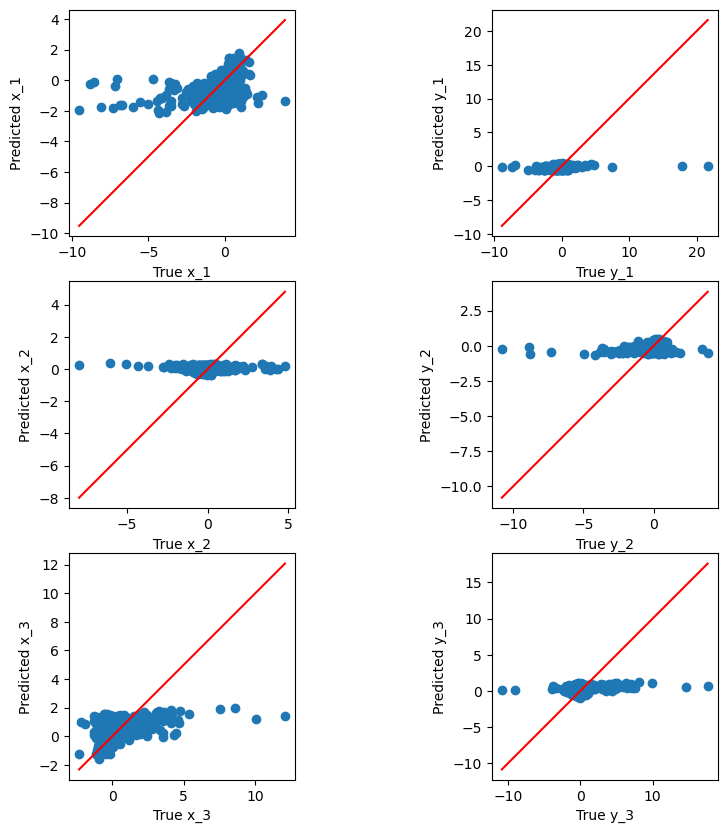

In [11]:
def plot_y_yhat(y_test,y_pred, plot_title = "plot"):
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    MAX = 500
    if len(y_test) > MAX:
        idx = np.random.choice(len(y_test),MAX, replace=False)
    else:
        idx = np.arange(len(y_test))
    plt.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_test[idx,i])
        x1 = np.max(y_test[idx,i])
        plt.subplot(3,2,i+1)
        plt.scatter(y_test[idx,i],y_pred[idx,i])
        plt.xlabel('True '+labels[i])
        plt.ylabel('Predicted '+labels[i])
        plt.plot([x0,x1],[x0,x1],color='red')
        plt.axis('square')
    plt.savefig(plot_title+'.pdf')
    plt.show()
    

plot_y_yhat(y_va, y_hat, plot_title="baseline_validation")


<h3>📤 Generate Kaggle Submission</h3>

In [12]:
#Preparing the dataset for training
full = train[~train["is_padding"]].copy()
X_full = full[FEATURES].values
y_full = full[TARGETS].values

#Baseline model
baseline_full = make_pipeline(StandardScaler(with_mean=True), LinearRegression())
baseline_full.fit(X_full, y_full)

#Preparing test
X_test = test[["t","x0_1","y0_1","x0_2","y0_2","x0_3","y0_3"]].values
pred = baseline_full.predict(X_test)

#Construct the submission
submission = pd.DataFrame({
    "Id": test["Id"].astype(np.int64),
    "x_1": pred[:,0], "y_1": pred[:,1],
    "x_2": pred[:,2], "y_2": pred[:,3],
    "x_3": pred[:,4], "y_3": pred[:,5],
})
submission.to_csv("baseline-model.csv", index=False)
print("Saved submission file: baseline-model.csv") 




Saved submission file: baseline-model.csv


<h3>📝 Task 2 -  Nonlinear models on the data — the Polynomial model</h3>

<h3>📝 Task 2.1 - Development</h3>

<h3> 🚀 Development — Polynomial Regression Validition</h3>

In [13]:
def pick_regressor(use_ridge=False, ridge_alphas=(0.01, 0.1, 1.0, 10.0, 100.0)):
    #Devolve o regressor a usar no fim do pipeline.
    return RidgeCV(alphas=np.array(ridge_alphas)) if use_ridge else LinearRegression()


def validate_polynomial(
    X_train, y_train, X_val, y_val,
    degrees=range(1, 8),        # testar graus 1..7 
    max_features=1500,          # não deixar explodir nº de colunas
    sample_frac=0.03,           # usar uma fração do treino para acelerar
    random_state=42,
    use_ridge=False,
    ridge_alphas=(0.01, 0.1, 1.0, 10.0, 100.0),
    verbose=True
):
    
    #Testa vários graus de PolynomialFeatures e escolhe o que dá menor RMSE na validação.
   #- Faz amostragem do treino (sample_frac) para ser rápido.
    #- Antes de treinar, verifica quantas features o grau vai gerar; se passar 'max_features', salta.
    #- Devolve: (best_model, best_rmse, logs) onde logs = [(grau, n_features, tempo, rmse), ...].
    
    rng = np.random.RandomState(random_state)

    # 1) Amostragem controlada do treino
    n = len(X_train)
    k = max(1, int(round(sample_frac * n)))
    idx = rng.choice(n, k, replace=False)
    X_sub = X_train[idx].astype(np.float32, copy=False)
    y_sub = y_train[idx].astype(np.float32, copy=False)

    Xv = X_val.astype(np.float32, copy=False)
    yv = y_val.astype(np.float32, copy=False)

    best_rmse = np.inf
    best_model = None
    logs = []
    n_in = X_sub.shape[1]

    for d in degrees:
        # 2) Ver quantas features o grau d vai gerar (sem treinar)
        probe = PolynomialFeatures(degree=d, include_bias=False)
        probe.fit(np.zeros((1, n_in), dtype=np.float32))
        n_feats = int(probe.n_output_features_)

        if max_features is not None and n_feats > max_features:
            if verbose:
                print(f"[skip] grau {d} → {n_feats} features (limite {max_features})")
            logs.append((d, n_feats, np.nan, np.nan))
            continue

        # 3) Construir pipeline e treinar
        model = pick_regressor(use_ridge=use_ridge, ridge_alphas=ridge_alphas)
        pipe = make_pipeline(
            PolynomialFeatures(degree=d, include_bias=False),
            StandardScaler(with_mean=True),
            model
        )

        t0 = time.time()
        pipe.fit(X_sub, y_sub)
        fit_time = time.time() - t0

        # 4) Validar
        pred = pipe.predict(Xv)
        rmse = float(np.sqrt(mean_squared_error(yv, pred)))

        logs.append((d, n_feats, fit_time, rmse))
        if verbose:
            print(f"degree={d:>2} | feats={n_feats:>5} | time={fit_time:6.2f}s | RMSE={rmse:7.4f}")

        if rmse < best_rmse:
            best_rmse = rmse
            best_model = pipe

    return best_model, best_rmse, logs


<h3>Run a simple validation (a “trial”)</h3>

In [14]:
# parâmetros práticos
DEGREES     = range(1, 8)
MAX_FEATURES= 1500
SAMPLE_FRAC = 0.03

print(" Linear Regression")
best_lin, rmse_lin, logs_lin = validate_polynomial(
    X_tr, y_tr, X_va, y_va,
    degrees=DEGREES,
    max_features=MAX_FEATURES,
    sample_frac=SAMPLE_FRAC,
    random_state=42,
    use_ridge=False,
    verbose=True
)
print(" Best RMSE (Linear):", rmse_lin, "\n")

print(" RidgeCV (L2 regularization)")
best_ridge, rmse_ridge, logs_ridge = validate_polynomial(
    X_tr, y_tr, X_va, y_va,
    degrees=DEGREES,
    max_features=MAX_FEATURES,
    sample_frac=SAMPLE_FRAC,
    random_state=42,
    use_ridge=True,
    ridge_alphas=(0.01, 0.1, 1.0, 10.0, 100.0),
    verbose=True
)
print(" Best RMSE (RidgeCV):", rmse_ridge)


 Linear Regression
degree= 1 | feats=    7 | time=  0.01s | RMSE= 1.4162
degree= 2 | feats=   35 | time=  0.02s | RMSE= 1.3778
degree= 3 | feats=  119 | time=  0.09s | RMSE= 1.3336
degree= 4 | feats=  329 | time=  0.32s | RMSE= 1.2972
degree= 5 | feats=  791 | time=  1.16s | RMSE= 1.2639
[skip] grau 6 → 1715 features (limite 1500)
[skip] grau 7 → 3431 features (limite 1500)
 Best RMSE (Linear): 1.2639124393463135 

 RidgeCV (L2 regularization)
degree= 1 | feats=    7 | time=  0.05s | RMSE= 1.4162
degree= 2 | feats=   35 | time=  0.15s | RMSE= 1.3779
degree= 3 | feats=  119 | time=  0.45s | RMSE= 1.3336
degree= 4 | feats=  329 | time=  1.48s | RMSE= 1.2975
degree= 5 | feats=  791 | time=  5.57s | RMSE= 1.2638
[skip] grau 6 → 1715 features (limite 1500)
[skip] grau 7 → 3431 features (limite 1500)
 Best RMSE (RidgeCV): 1.2637505271560925


<h3>Save number of features and times for slides</h3>

In [15]:
def logs_to_df(logs):
    return pd.DataFrame(logs, columns=["degree","n_features","fit_time_s","rmse_val"])

df_lin   = logs_to_df(logs_lin)
df_ridge = logs_to_df(logs_ridge)

print("Linear summary:\n", df_lin)
print("\nRidgeCV summary:\n", df_ridge)



Linear summary:
    degree  n_features  fit_time_s  rmse_val
0       1           7    0.014763  1.416203
1       2          35    0.019759  1.377826
2       3         119    0.088098  1.333596
3       4         329    0.321377  1.297196
4       5         791    1.155488  1.263912
5       6        1715         NaN       NaN
6       7        3431         NaN       NaN

RidgeCV summary:
    degree  n_features  fit_time_s  rmse_val
0       1           7    0.046349  1.416246
1       2          35    0.151873  1.377876
2       3         119    0.449090  1.333636
3       4         329    1.480608  1.297471
4       5         791    5.574523  1.263751
5       6        1715         NaN       NaN
6       7        3431         NaN       NaN


<h3>Repeat 10 times and plot the best grade distribution</h3>

Best degrees across 10 runs: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


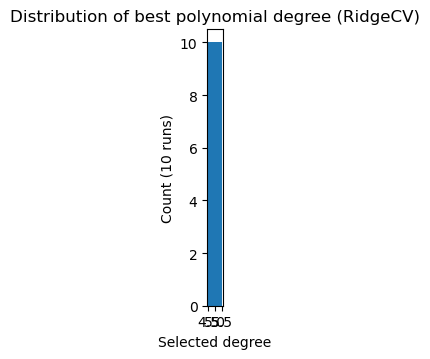

✅ Final chosen degree: 5


In [16]:
best_degrees = []
for seed in range(1, 11):
    mdl, rmse, logs = validate_polynomial(
        X_tr, y_tr, X_va, y_va,
        degrees=DEGREES,
        max_features=MAX_FEATURES,
        sample_frac=0.05,      # um pouco mais para dar estabilidade
        random_state=seed,
        use_ridge=True,
        ridge_alphas=(0.01, 0.1, 1.0, 10.0, 100.0),
        verbose=False
    )
    df = logs_to_df(logs).dropna(subset=["rmse_val"])
    best_deg = int(df.loc[df["rmse_val"].idxmin(), "degree"])
    best_degrees.append(best_deg)

print("Best degrees across 10 runs:", best_degrees)

plt.figure(figsize=(1,3.7))
plt.hist(best_degrees, bins=np.arange(min(best_degrees)-0.5, max(best_degrees)+1.5, 1))
plt.xlabel("Selected degree"); plt.ylabel("Count (10 runs)")
plt.title("Distribution of best polynomial degree (RidgeCV)")
plt.tight_layout(); plt.show()

# escolher o grau final (moda)
from collections import Counter
final_degree = Counter(best_degrees).most_common(1)[0][0]
print("✅ Final chosen degree:", final_degree)


<h3>📝 Task 2.2 - compare with baseline and submit</h3>

<h3>📊 Compare RMSE + y–ŷ plots</h3>

Chosen model: Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=5, include_bias=False)),
                ('standardscaler', StandardScaler()),
                ('ridgecv',
                 RidgeCV(alphas=array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])))])
Polynomial RMSE (validation): 1.2637506527677478


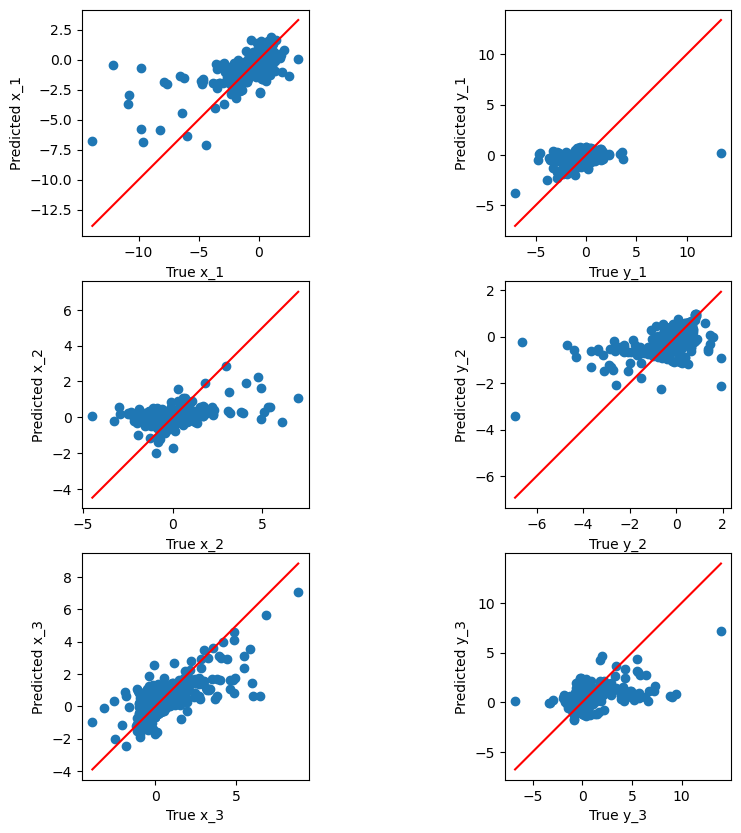

In [17]:
# entre Linear e Ridge, fica o melhor
chosen_model = best_ridge if rmse_ridge <= rmse_lin else best_lin
print("Chosen model:", chosen_model)

y_va_pred = chosen_model.predict(X_va)
rmse_poly = float(np.sqrt(mean_squared_error(y_va, y_va_pred)))
print("Polynomial RMSE (validation):", rmse_poly)

# gráfico y–ŷ (mesma função que já usaste na Task 1)
_ = plot_y_yhat(y_va, y_va_pred, plot_title="poly_validation")


<h3>📄 Train on the full dataset (without padding) and submit to Kaggle</h3>

In [20]:
# treinar no máximo de dados possível (sem padding)
full = train[~train["is_padding"]].copy()
X_full = full[FEATURES].values
y_full = full[TARGETS].values

# reconstruir pipeline com o GRAU final e o tipo de regressor escolhido
is_ridge = isinstance(chosen_model.named_steps[list(chosen_model.named_steps.keys())[-1]], RidgeCV)
reg_final = pick_regressor(use_ridge=is_ridge, ridge_alphas=(0.01, 0.1, 1.0, 10.0, 100.0))

final_model = make_pipeline(
    PolynomialFeatures(degree=int(final_degree), include_bias=False),
    StandardScaler(with_mean=True),
    reg_final
)
final_model.fit(X_full, y_full)

# prever no test
X_test_arr = test[["t","x0_1","y0_1","x0_2","y0_2","x0_3","y0_3"]].values
pred = final_model.predict(X_test_arr)

# salvar submissão
polysub = pd.DataFrame({
    "Id": test["Id"].astype(np.int64),
    "x_1": pred[:,0], "y_1": pred[:,1],
    "x_2": pred[:,2], "y_2": pred[:,3],
    "x_3": pred[:,4], "y_3": pred[:,5],
})
polysub.to_csv("polynomial_submission.csv", index=False)
print(f"Saved: polynomial_submission.csv (degree={final_degree}, ridge={is_ridge})")


Saved: polynomial_submission.csv (degree=5, ridge=True)


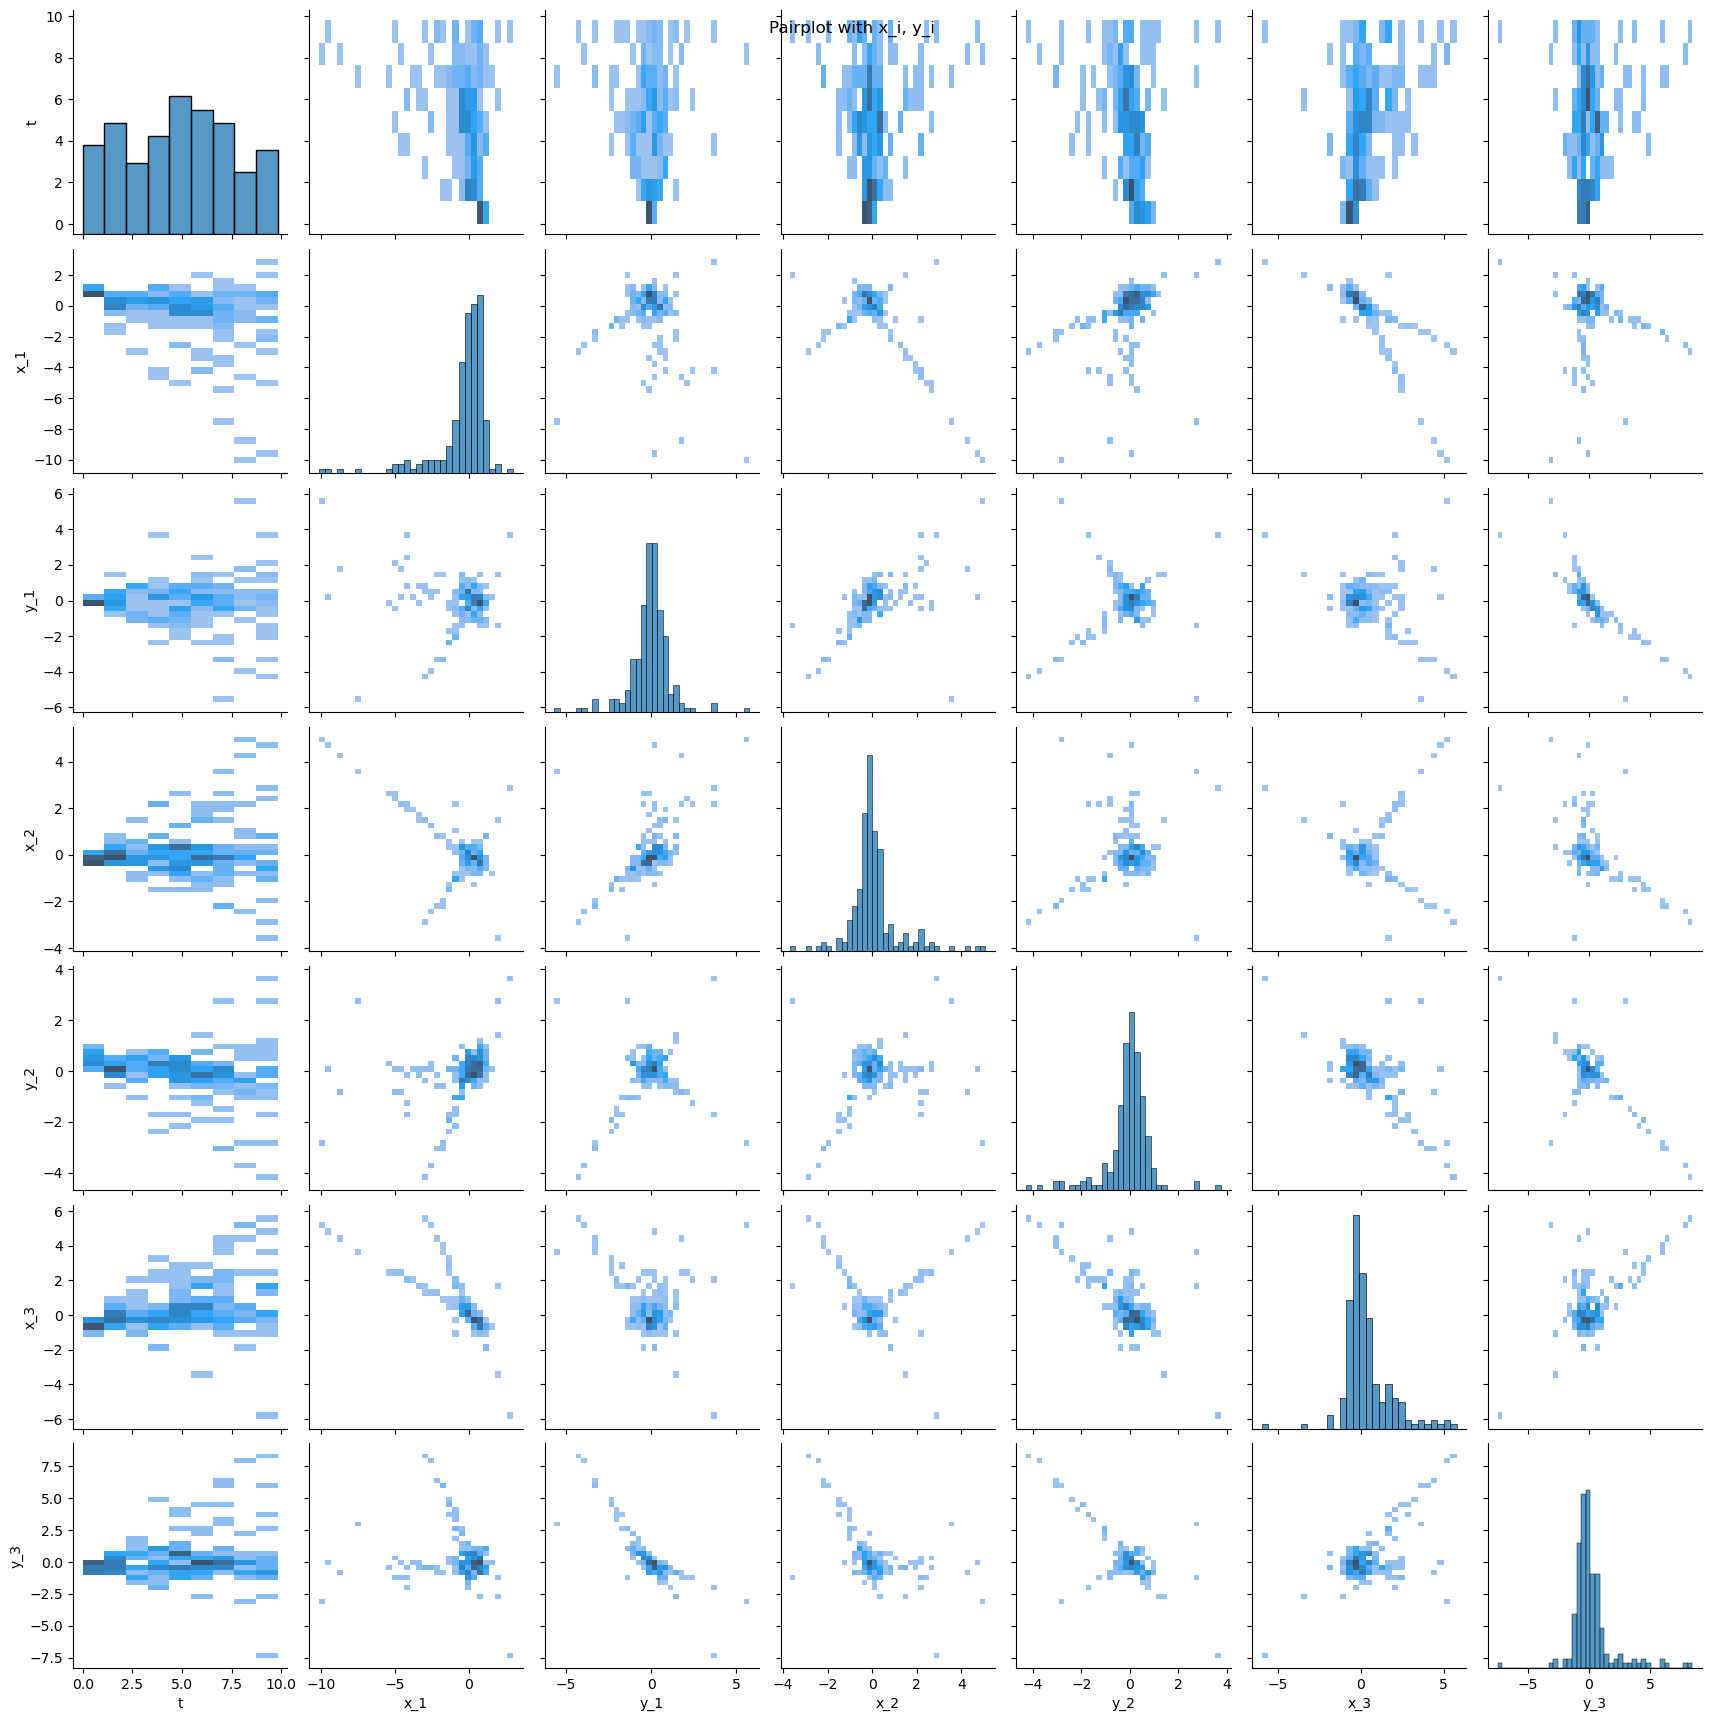

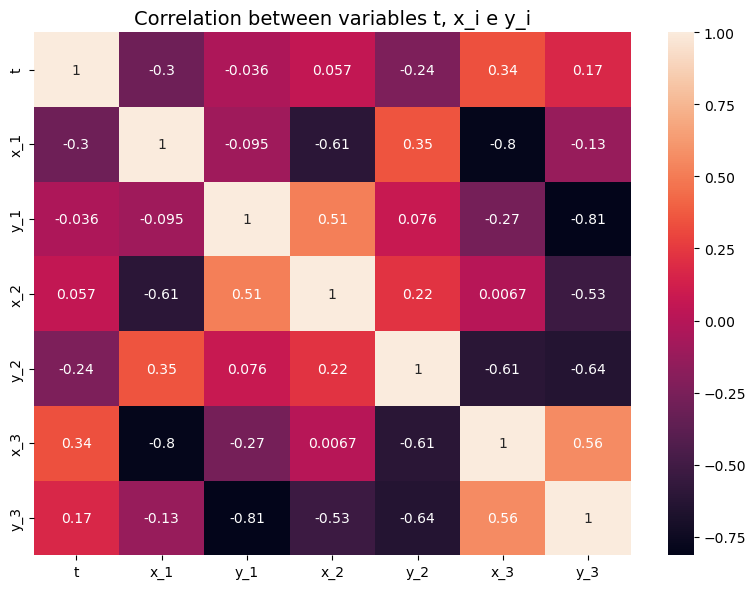

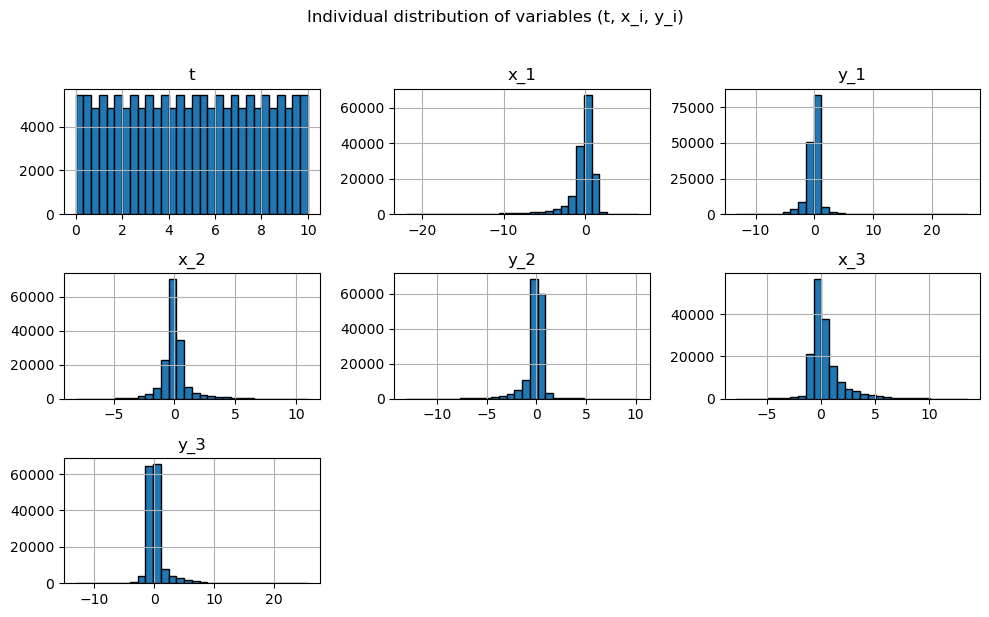

Correlations by order:

t    t      1.000000
y_1  y_3   -0.814632
x_1  x_3   -0.798063
y_2  y_3   -0.640459
     x_3   -0.610174
x_1  x_2   -0.607937
x_3  y_3    0.563446
x_2  y_3   -0.525322
y_1  x_2    0.514985
x_1  y_2    0.351193
t    x_3    0.339845
     x_1   -0.304254
y_1  x_3   -0.270725
t    y_2   -0.237880
x_2  y_2    0.221190
t    y_3    0.166106
x_1  y_3   -0.130825
     y_1   -0.095367
y_1  y_2    0.076320
t    x_2    0.057114
     y_1   -0.036011
x_2  x_3    0.006737
dtype: float64
 Baseline RMSE (WITHOUT REMOVAL): 1.2611103091896443
Removed t → 6 features left
Removed x0_1 → 6 features left
Removed y0_1 → 6 features left
Removed x0_2 → 6 features left
Removed y0_2 → 6 features left
Removed x0_3 → 6 features left
Removed y0_3 → 6 features left
Removed      t  RMSE = 1.4587929952436265


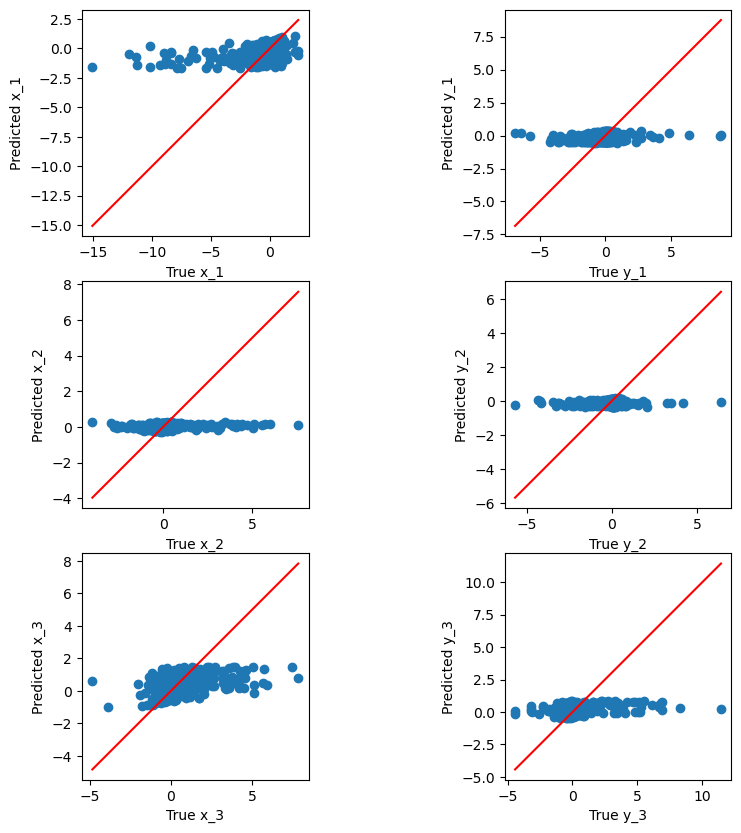

Removed   x0_1  RMSE = 1.415888436301919


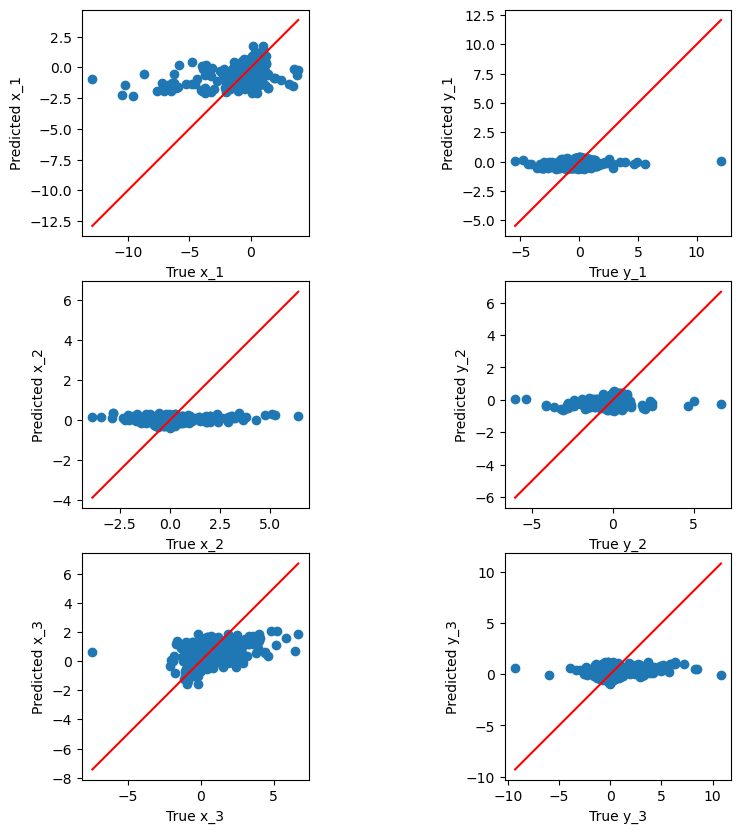

Removed   y0_1  RMSE = 1.415888436301919


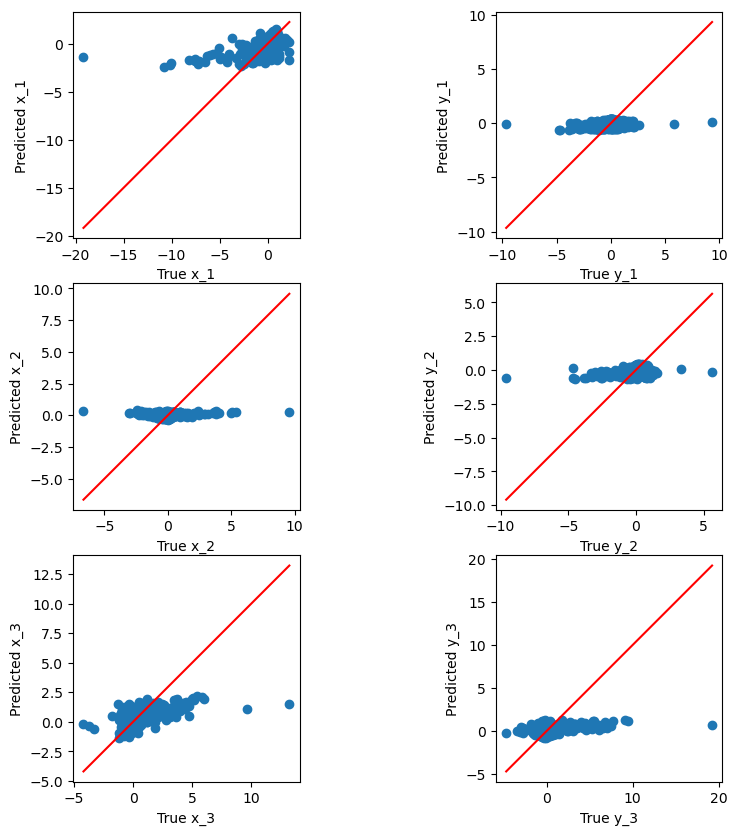

Removed   x0_2  RMSE = 1.4158765843497938


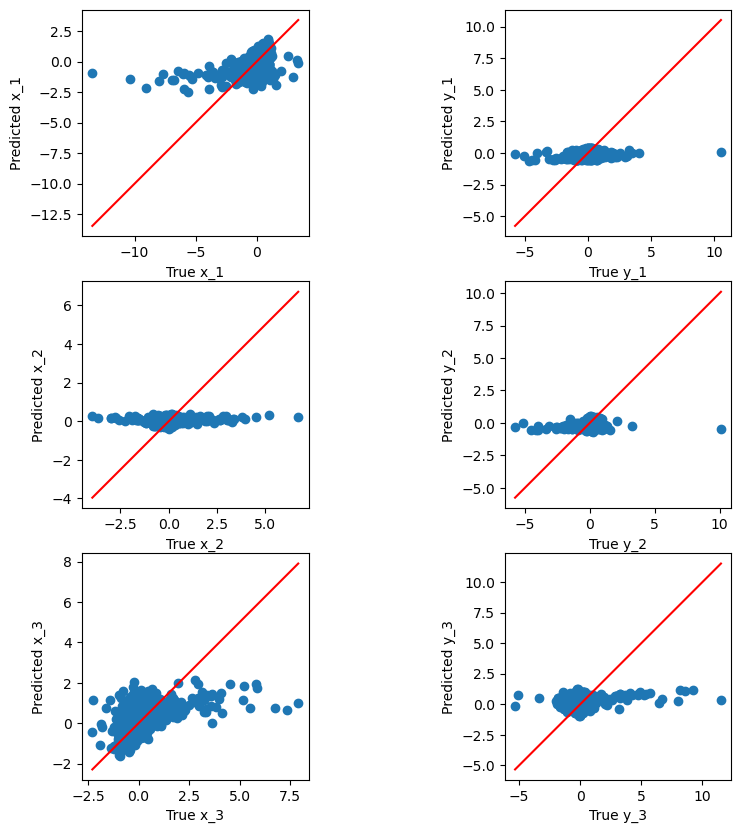

Removed   y0_2  RMSE = 1.4159190934045662


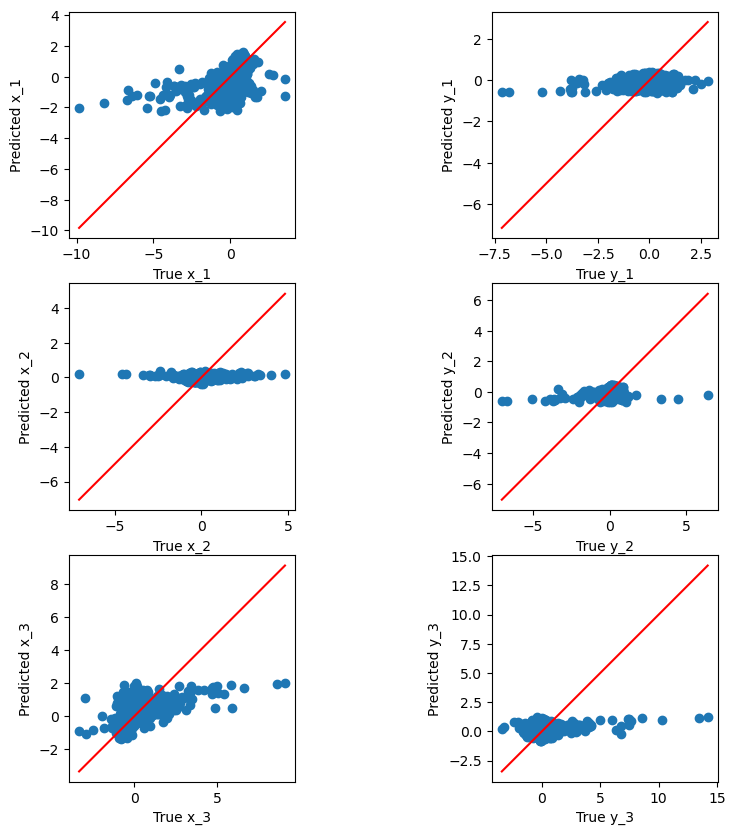

Removed   x0_3  RMSE = 1.4158767656460323


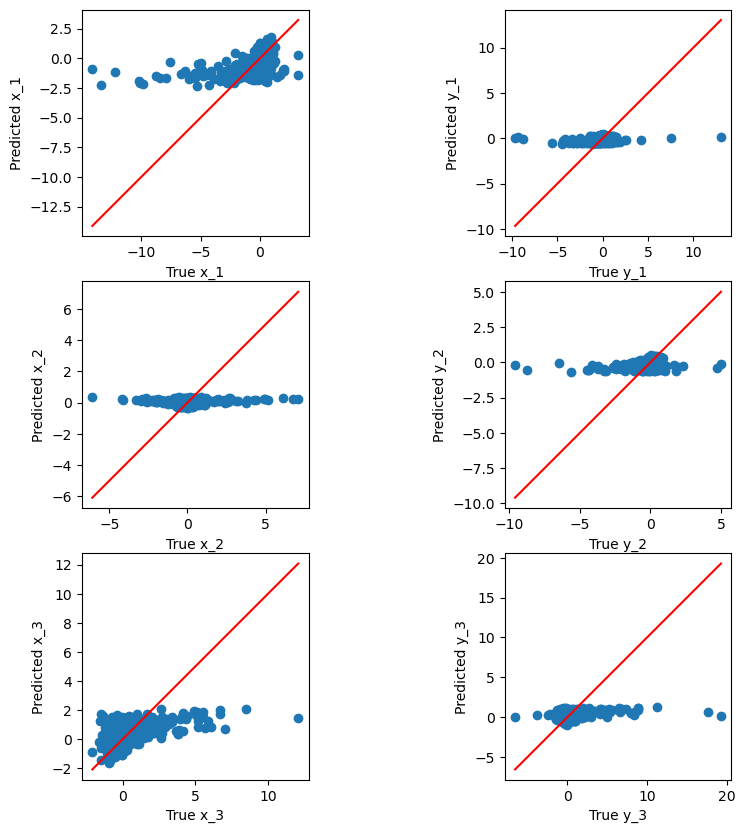

Removed   y0_3  RMSE = 1.4159184576665156


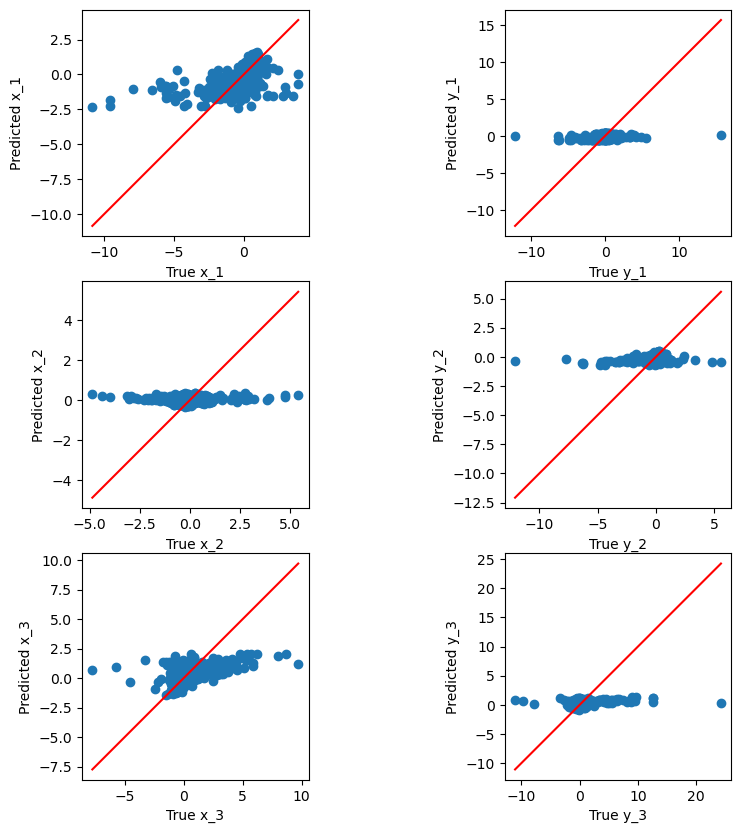

Impact of removing each feature:
  Removed Feature      RMSE
3            x0_2  1.415877
5            x0_3  1.415877
1            x0_1  1.415888
2            y0_1  1.415888
6            y0_3  1.415918
4            y0_2  1.415919
0               t  1.458793


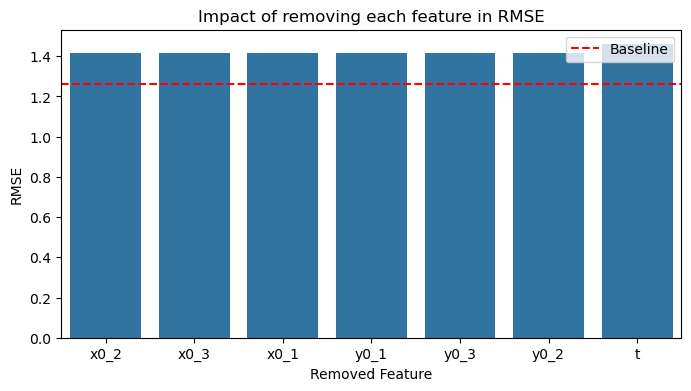

In [18]:

############# Task 3.1 #############

#We want to correlate the variables "t" (features), and "x_1","y_1",x_2","y_2","x_3" and "y_3" (targets)
#Go get variable t from features
t_features=FEATURES.index("t")
t = X_va[:, t_features] #t is an array contains every value for each "t" (features)

#Join the values from "t" in X_val and x_1","y_1",x_2","y_2","x_3" and "y_3" in y_val
data=np.column_stack((t, y_va)) #Stack o t with y_val
cols=["t"]+TARGETS #Names of columns
df=pd.DataFrame(data, columns=cols) #forms the datatframe

#Pairplot
sns.pairplot(df.sample(200), kind="hist") #Sample of 200 to limit noise 
plt.suptitle("Pairplot with x_i, y_i") 
plt.show()

#Heatmap with correlation
corr=df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True)
plt.title("Correlation between variables t, x_i e y_i", fontsize=14),
plt.tight_layout()
plt.show()

#Histograms of individual distributions 
df.hist(bins=30, figsize=(10,6), edgecolor='black')
plt.suptitle("Individual distribution of variables (t, x_i, y_i)", y=1.02)
plt.tight_layout()
plt.show()

#Sort the interactions by the correlation values
corr_pairs=corr.unstack()  #Transform in series and pairs of variables
corr_pairs=corr_pairs.drop_duplicates()  #Removes duplicates (A,B) and (B,A)
sorted_corr=corr_pairs.reindex(corr_pairs.abs().sort_values(ascending=False).index)
print("Correlations by order:\n")
print(sorted_corr)

#Prininting RMSE without any removal 
baseline_rmse=rmse 
print(f" Baseline RMSE (WITHOUT REMOVAL): {baseline_rmse}")

#List do keep results 
results=[]

#Removing each feature
#For each feature in FEATURES
for feat in FEATURES:
    features_temporary = [f for f in FEATURES if f != feat]
    print(f"Removed {feat} → {len(features_temporary)} features left")

for feat in FEATURES:
    features_temporary=[f for f in FEATURES if f!= feat] #List of temporary features, is going to contain every feature minus the one that we want to measure the impact 
    
    #Creates new datasets 
    #tr_df contains every feature from training set ("t", "x_0_1", "y_0_1","x_0_2","y_0_2","x_0_3","y_0_3","x_1","y_1","x_2","y_2","x_3","y_3")
    #tr_df contains every feature from validation set ("t", "x_0_1", "y_0_1","x_0_2","y_0_2","x_0_3","y_0_3","x_1","y_1","x_2","y_2","x_3","y_3")
    X_tr_red = tr_df[features_temporary].values #Selects the "t", "x_0_1", "y_0_1","x_0_2","y_0_2","x_0_3","y_0_3"
    y_tr_red = tr_df[TARGETS].values #Selects "x_1","y_1","x_2","y_2","x_3","y_3"
    X_va_red = va_df[features_temporary].values 
    y_va_red = va_df[TARGETS].values
    
    #New model 
    model_red = make_pipeline(StandardScaler(with_mean=True), LinearRegression()) #Calls the regression pipeline
    model_red.fit(X_tr_red, y_tr_red)#Trains and validates with data with removed feature
    y_hat_red = model_red.predict(X_va_red)  #Previsions for each "x_1","y_1","x_2","y_2","x_3","y_3"
    
    #Calculate RMSE
    rmse_red = np.sqrt(mean_squared_error(y_va_red, y_hat_red))
    
    #Adds to the list the removed feature and the RMSE value for the prevision without the removed feature
    results.append({
        "Removed Feature": feat,
        "RMSE": rmse_red})
    print(f"Removed {feat:>6}  RMSE = {rmse_red}")
    
    #Plot y–ŷ for each removal
    plot_y_yhat(y_va_red, y_hat_red, plot_title=f"remove_{feat}_validation")

#Converts to DataFrame
results_df = pd.DataFrame(results).sort_values("RMSE")
print("Impact of removing each feature:")
print(results_df)

#Comparative plot for slides 
plt.figure(figsize=(8,4))
sns.barplot(data=results_df, x="Removed Feature", y="RMSE") #
plt.axhline(baseline_rmse, color='red', linestyle='--', label='Baseline')
plt.title("Impact of removing each feature in RMSE")
plt.legend()
plt.show()

degree= 1 | feats=    1 | time=  0.00s | RMSE= 1.4754
degree= 2 | feats=    2 | time=  0.01s | RMSE= 1.4739
degree= 3 | feats=    3 | time=  0.01s | RMSE= 1.4734
degree= 4 | feats=    4 | time=  0.01s | RMSE= 1.4728
degree= 5 | feats=    5 | time=  0.01s | RMSE= 1.4726
Best RMSE with reduced Features: 1.4726396799087524


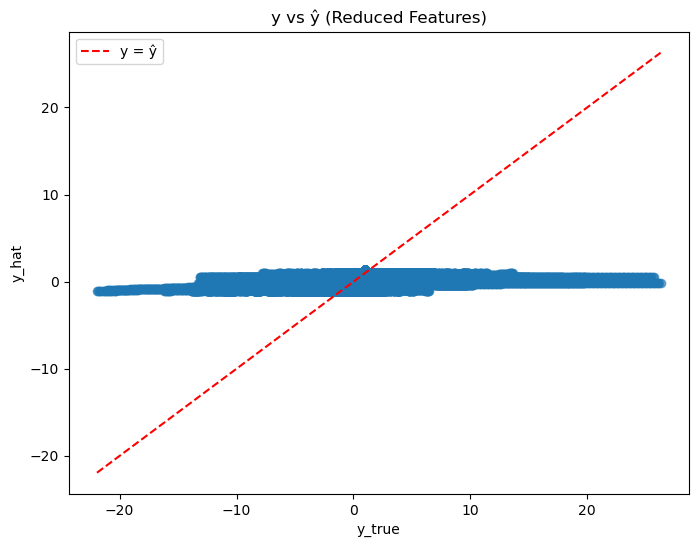

RMSE Task 2: 1.2637506527677478
RMSE model with reduced features: 1.4726396799087524
reduced_polynomial_submission.csv created for submission to Kaggle.


In [20]:
############# Task 3.2 #############

#Creating only datatsets with variable "t" in features (X_tr and X_va)
X_tr_reduced = tr_df[["t"]].values 
X_va_reduced = va_df[["t"]].values
y_tr_reduced = tr_df[TARGETS].values
y_va_reduced = va_df[TARGETS].values

best_model_red, best_rmse_red, logs_red = validate_polynomial(
    X_tr_reduced, y_tr_reduced,
    X_va_reduced, y_va_reduced,
    degrees=range(1, 6),  
    max_features=1500,
    random_state=42,
    use_ridge=False,
    sample_frac=0.05,
    verbose=True
)

print(f"Best RMSE with reduced Features: {best_rmse_red}")

#Y-^y plot for comparing values
y_hat_red = best_model_red.predict(X_va_reduced) #Using prediction with reduced features on validation set

plt.figure(figsize=(8,6))
plt.scatter(y_va_reduced.flatten(), y_hat_red.flatten(), alpha=0.6)
plt.plot([y_va_reduced.min(), y_va_reduced.max()],
         [y_va_reduced.min(), y_va_reduced.max()],
         'r--', label='y = ŷ')
plt.xlabel('y_true')
plt.ylabel('y_hat')
plt.title('y vs ŷ (Reduced Features)')
plt.legend()
plt.show()

#Comparison with Task 2
print(f"RMSE Task 2: {rmse_poly}")
print(f"RMSE model with reduced features: {best_rmse_red}")

#Submission to Kaggle
X_test_reduced = test[["t"]].values
y_test_reduced = best_model_red.predict(X_test_reduced)

reduced = pd.DataFrame({
    "Id": test["Id"].astype(np.int64),
    "x_1": y_test_reduced[:,0], "y_1": y_test_reduced[:,1],
    "x_2": y_test_reduced[:,2], "y_2": y_test_reduced[:,3],
    "x_3": y_test_reduced[:,4], "y_3": y_test_reduced[:,5],
})
submission.to_csv("reduced_polynomial_submission.csv", index=False)
print("reduced_polynomial_submission.csv created for submission to Kaggle.")

In [21]:
############ Task 3.3 #############

#Adding new features
def add_new_features (df):
    eps = 1e-8 #Small value to avoid division by zero
    
    #Inverse of position (1/a)
    df["1/x0_1"]=1/(df["x0_1"]+eps)
    df["1/y0_1"]=1/(df["y0_1"]+eps)
    df["1/x0_2"]=1/(df["x0_2"]+eps)
    df["1/y0_2"]=1/(df["y0_2"]+eps)
    df["1/x0_3"]=1/(df["x0_3"]+eps)
    df["1/y0_3"]=1/(df["y0_3"]+eps)
    
    #Norms (sqrt(a^2))
    df["norm_1"] =np.sqrt(df["x0_1"]**2 + df["y0_1"]**2)
    df["norm_2"] =np.sqrt(df["x0_2"]**2 + df["y0_2"]**2)
    df["norm_3"] =np.sqrt(df["x0_3"]**2 + df["y0_3"]**2)
    
    #Distance between pairs (sqrt(a^2+b^2))
    df["distance_1_2"]=np.sqrt((df["x0_1"]-df["x0_2"])**2 + ((df["y0_1"]-df["y0_2"])**2))
    df["distance_1_3"]=np.sqrt((df["x0_1"]-df["x0_3"])**2 + ((df["y0_1"]-df["y0_3"])**2))
    df["distance_2_3"]=np.sqrt((df["x0_2"]-df["x0_3"])**2 + ((df["y0_2"]-df["y0_3"])**2))

    #Geometric center
    df["distance_of_x"]=(df["x0_1"] + df["x0_2"] + df["x0_3"]) / 3
    df["distance_of_y"]=(df["y0_1"] + df["y0_2"] + df["y0_3"]) / 3

    return df

#Apply to train and validation sets
train_new_features=add_new_features(tr_df)
validate_new_features=add_new_features(va_df)

#Updating the features set
NEW_FEATURES= FEATURES + [
    "1/x0_1","1/y0_1","1/x0_2","1/y0_2","1/x0_3","1/y0_3",
    "norm_1","norm_2","norm_3",
    "distance_1_2","distance_1_3","distance_2_3",
    "distance_of_x","distance_of_y"]

#Creating the new datasets
X_tr_new_features=train_new_features[NEW_FEATURES].values
y_tr_new_features=train_new_features[TARGETS].values
X_va_new_features=validate_new_features[NEW_FEATURES].values
y_va_new_features=validate_new_features[TARGETS].values

#Training baseline model with new added features
baseline_new_features = make_pipeline(StandardScaler(with_mean=True), LinearRegression())
baseline_new_features.fit(X_tr_new_features, y_tr_new_features)
y_hat_new_features = baseline_new_features.predict(X_va_new_features)  #Prevision in validation datatset

#Print the results
rmse_new_features = np.sqrt(mean_squared_error(y_va_new_features, y_hat_new_features))
print(f"Baseline RMSE (validation split) with new features: {rmse_new_features}")
print(f"RMSE Baseline original: {rmse_baseline}")

Baseline RMSE (validation split) with new features: 1.365132755373551
RMSE Baseline original: 1.415889079322975


In [ ]:
############ Task 3.4 #############

def add_new_features_augmentation (X):
    df=pd.DataFrame(X, columns=FEATURES)
    df_augmented=add_new_features(df)
    return df_augmented.values

#Using ColumnTransformer and FunctionTransformer to add new features 
#Augmenter applies the function add_new_features_augmentation to the columns in FEATURES
augmenter=FunctionTransformer(add_new_features_augmentation, validate=False)

#Applies the augmenter to the columns in FEATURES and leaves the rest of the columns unchanged
preprocessor=ColumnTransformer(
    transformers=[
        ('augment', augmenter, FEATURES)],
    remainder="passthrough")

#Pipeline with augmented features
#Transforms X_tr in X_aumented with the new features
polynomial_augmentation = make_pipeline(
    preprocessor,
    PolynomialFeatures(degree=final_degree, include_bias=False), #Using only the best degree (should be 5)
    StandardScaler(with_mean=True),
    pick_regressor(use_ridge=True, ridge_alphas=(0.01, 0.1, 1.0, 10.0, 100.0))
)

X_tr = pd.DataFrame(X_tr, columns=FEATURES)
X_va = pd.DataFrame(X_va, columns=FEATURES)
X_test = pd.DataFrame(X_test, columns=FEATURES)
test_ids = test["Id"].astype(np.int64)

# Training the model with augmented features
polynomial_augmentation.fit(X_tr, y_tr)
y_hat_augmented=polynomial_augmentation.predict(X_va)  #Prevision

#y–ŷ plot for comparing values
plt.figure(figsize=(6,6))
plt.scatter(y_va, y_hat_augmented, alpha=0.6)
plt.plot([y_va.min(), y_va.max()], [y_va.min(), y_va.max()], 'r--')
plt.xlabel("Actual y")
plt.ylabel("Predicted ŷ")
plt.title("y vs ŷ (Augmented Polynomial Model)")
plt.show()

#Print the results
rmse_augmented = np.sqrt(mean_squared_error(y_va, y_hat_augmented))
print(f"Polynomial RMSE (validation) with augmented features: {rmse_augmented}")
print(f"Polynomial RMSE (validation) without augmented features: {rmse_poly}")

#Exportation to Kaggle
X_test_augmentation = test[["t"]].values
y_test = polynomial_augmentation.predict(X_test)

#Salvar submissão
augmentation = pd.DataFrame({
    "Id": test["Id"].astype(np.int64),
    "x_1": y_test[:,0], "y_1": y_test[:,1],
    "x_2": y_test[:,2], "y_2": y_test[:,3],
    "x_3": y_test[:,4], "y_3": y_test[:,5],
})

augmentation.to_csv("augmented_polynomial_submission.csv", index=False)